In [2]:
# импортируем необходимые модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import integrate, optimize
from sklearn import preprocessing, model_selection, metrics
from sklearn.cluster import KMeans
# from kneed import KneeLocator не робатает пока у меня почему-то
from IPython.display import display

In [3]:
%matplotlib inline

In [4]:
# загружаем данные из файла в формате CSV, указываем символ-разделитель и сохраняем данные в дата-фрейм (переменную df)
df = pd.read_csv('../data/marketing_campaign.csv',sep='\t')
# проверяем, что данные загрузились - выводим первые несколько строк таблицы
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Признаки:
- ID - уникальный идентификатор клиента 
- Year_Birth - год рождения клиента 
- Education - уровень образования  
- Marital_Status - семейное положение  
- Income - годовой доход семьи клиента 
- Kidhome - количество детей до 12 лет в семье
- Teenhome - количество подростков 13-18 лет в семье
- Dt_Customer - дата регистрации клиента
- Recency - количество дней с момента последней покупки
- MntWines - траты на вино
- MntFruits - траты на фрукты
- MntMeatProducts - траты на мясо
- MntFishProducts - траты на рыбу
- MntSweetProducts - траты на сладости
- MntGoldProds - траты на золото (ювелирные изделия)
- NumDealsPurchases - покупки со скидкой
- NumWebPurchases - покупки через сайт
- NumCatalogPurchases - покупки по каталогу
- NumStorePurchases - покупки в магазине
- NumWebVisitsMonth - количество посещений сайта в месяц
- AcceptedCmp1 - участие в 1-й кампании 
- AcceptedCmp2 - участие во 2-й кампании 
- AcceptedCmp3 - участие в 3-й кампании 
- AcceptedCmp4 - участие в 4-й кампании 
- AcceptedCmp5 - участие в 5-й кампании 
- Complain - подавал ли жалобу за последние 2 года 
- Z_CostContact - техническая колонка 
- Z_Revenue - техническая колонка 
- Response - отклик на предложение в последней кампании (1 - согласился, 0 - отказался)

In [ ]:
# объём данных (строк и столбцов - объектов и признаков)
df.shape

In [ ]:
# выводим типы данных
df.dtypes

In [ ]:
# целевой признак Response

In [ ]:
print(df.describe())

In [5]:
# описательная статистика для всех (числовых) признаков
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


In [ ]:
df.info()

In [ ]:
# имена колонок в виде списка
df.columns

In [ ]:
# проверка на отсутствующие значения для всех колонок датафрейма
df.isnull().sum()


In [ ]:
# в ходе проверки данных обнаружилось, что в колонке Income есть пропуски


In [ ]:
# посмотрел колонки на дубликаты
df.duplicated().sum()

In [ ]:
df.nunique()

In [11]:
# создаём копию датафрейма для дальнейшего анализа и преобразований, чтобы не изменять исходные данные
df_eda = df.copy()

In [12]:
# удаляем колонки Z_CostContact, Z_Revenue так как они используются для расчета затрат и  не несут полезной информации для анализа
drop_cols = ['Z_CostContact', 'Z_Revenue']
df_eda = df_eda.drop(columns=[col for col in drop_cols if col in df_eda.columns])

In [34]:
# Заполнить медианным доходом для людей с таким же образованием и семейным положением
df['Income'] = df.groupby(['Education', 'Marital_Status'])['Income']\
                 .transform(lambda x: x.fillna(x.median()))

In [35]:
# проверка
df.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

In [13]:
# Общие траты
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_eda['Total_Spending'] = df_eda[spending_cols].sum(axis=1)

In [14]:
# Общие покупки
purchase_cols = ['NumDealsPurchases', 'NumWebPurchases', 
                 'NumCatalogPurchases', 'NumStorePurchases']
df_eda['Total_Purchases'] = df_eda[purchase_cols].sum(axis=1)

In [15]:
# Средний чек
df_eda['Avg_Check'] = df_eda['Total_Spending'] / df_eda['Total_Purchases'].replace(0, np.nan)


In [ ]:
# Участие в кампаниях
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 
                 'AcceptedCmp4', 'AcceptedCmp5']
df_eda['Total_Accepted_Cmp'] = df_eda[campaign_cols].sum(axis=1)
df_eda['Accepted_Any'] = (df_eda['Total_Accepted_Cmp'] > 0).astype(int)

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_eda['Income'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='green')
plt.title('Распределение дохода', fontsize=14)
plt.xlabel('Доход')
plt.ylabel('Частота')
plt.show()

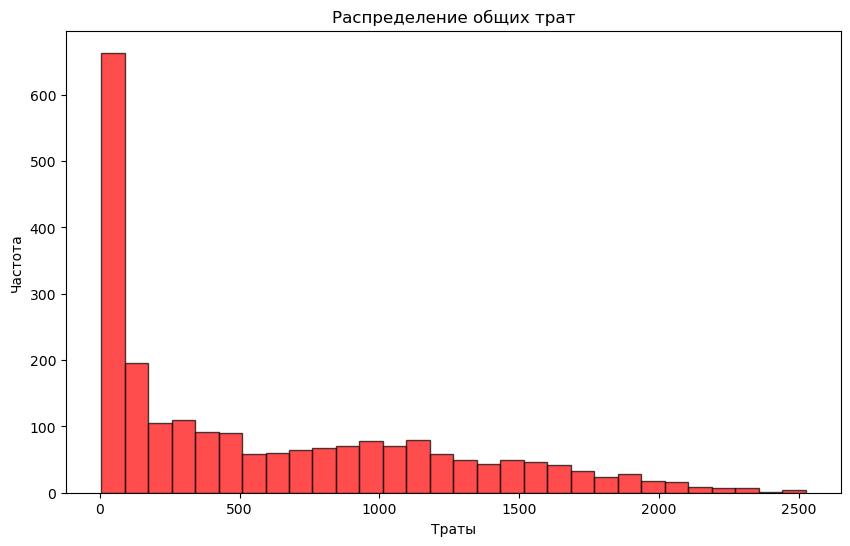

In [19]:
# Общие траты
plt.figure(figsize=(10, 6))
plt.hist(df_eda['Total_Spending'], bins=30, edgecolor='black', alpha=0.7, color='red')
plt.title('Распределение общих трат')
plt.xlabel('Траты')
plt.ylabel('Частота')
plt.show()

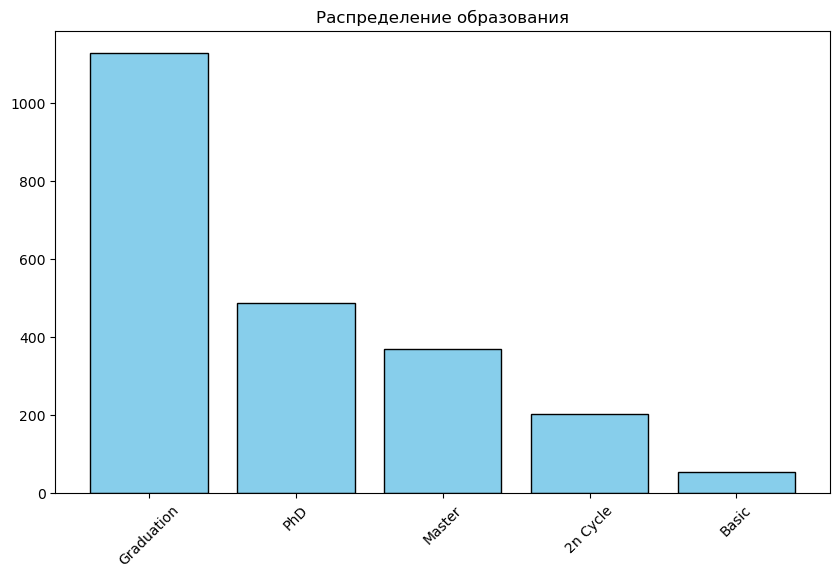

In [20]:
edu_counts = df_eda['Education'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(edu_counts.index, edu_counts.values, color='skyblue', edgecolor='black')
plt.title('Распределение образования')
plt.tick_params(axis='x', rotation=45)
plt.show()


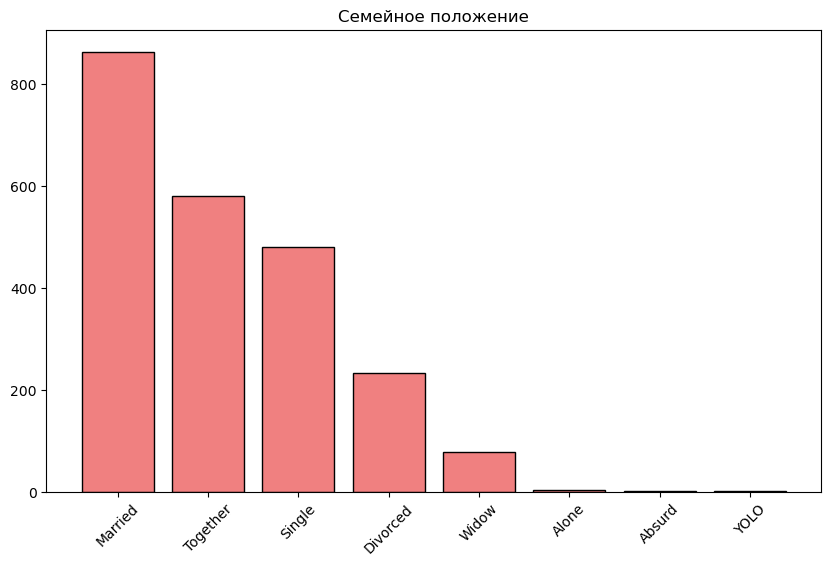

In [21]:
plt.figure(figsize=(10, 6))
marital_counts = df_eda['Marital_Status'].value_counts()
plt.bar(marital_counts.index, marital_counts.values, color='lightcoral', edgecolor='black')
plt.title('Семейное положение')
plt.tick_params(axis='x', rotation=45)
plt.show()

In [ ]:
# Средние траты по категориям
avg_spending = df_eda[spending_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(avg_spending.index, avg_spending.values, color='skyblue', edgecolor='black')
plt.title('Средние траты по категориям', fontsize=14)
plt.xlabel('Категория')
plt.ylabel('Средние траты')
plt.xticks(rotation=45)

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nСредние траты по категориям:")
print(avg_spending)

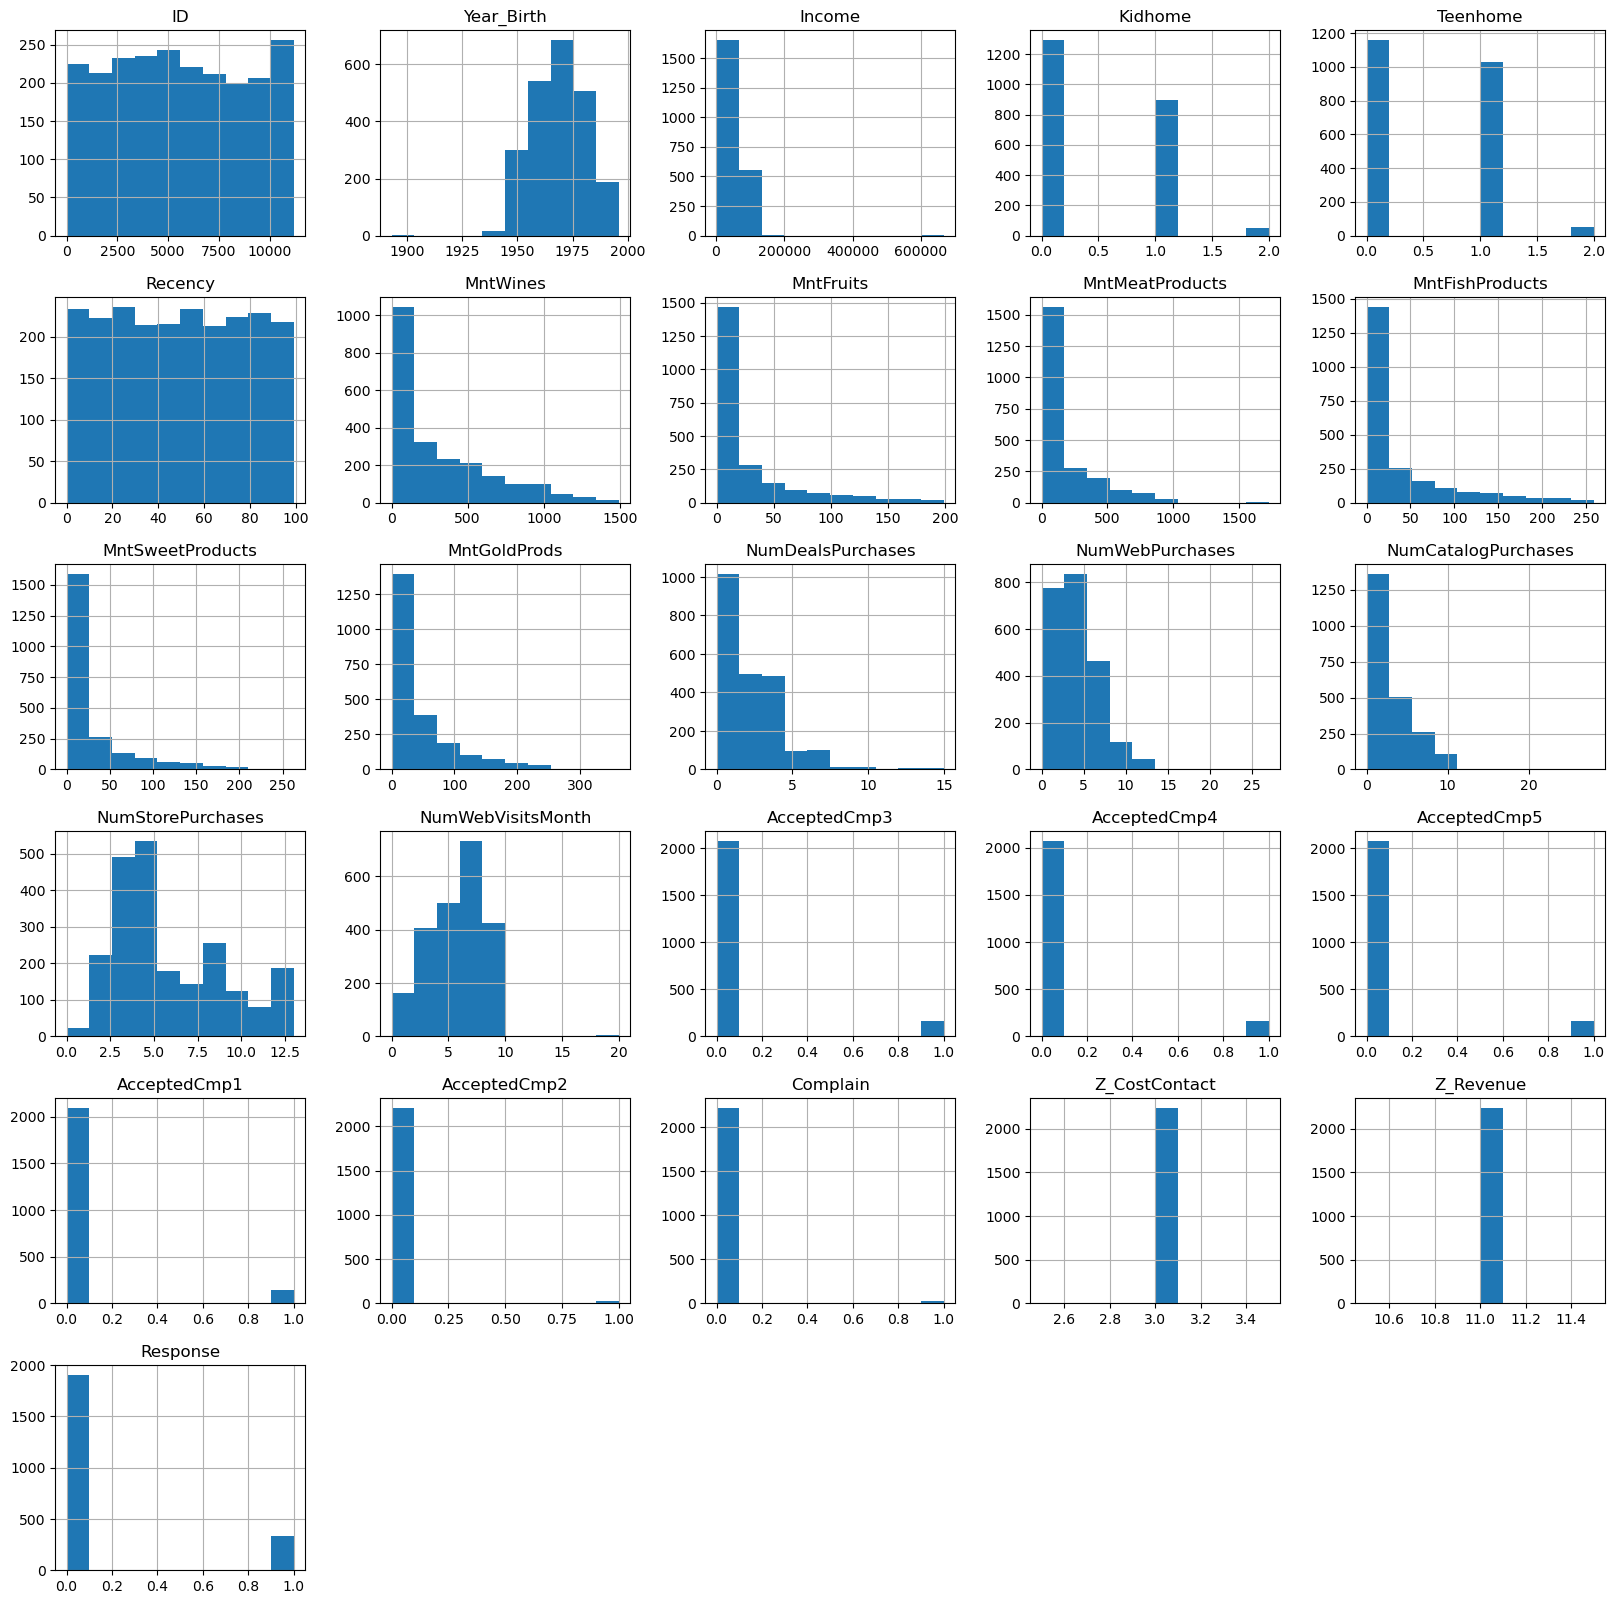

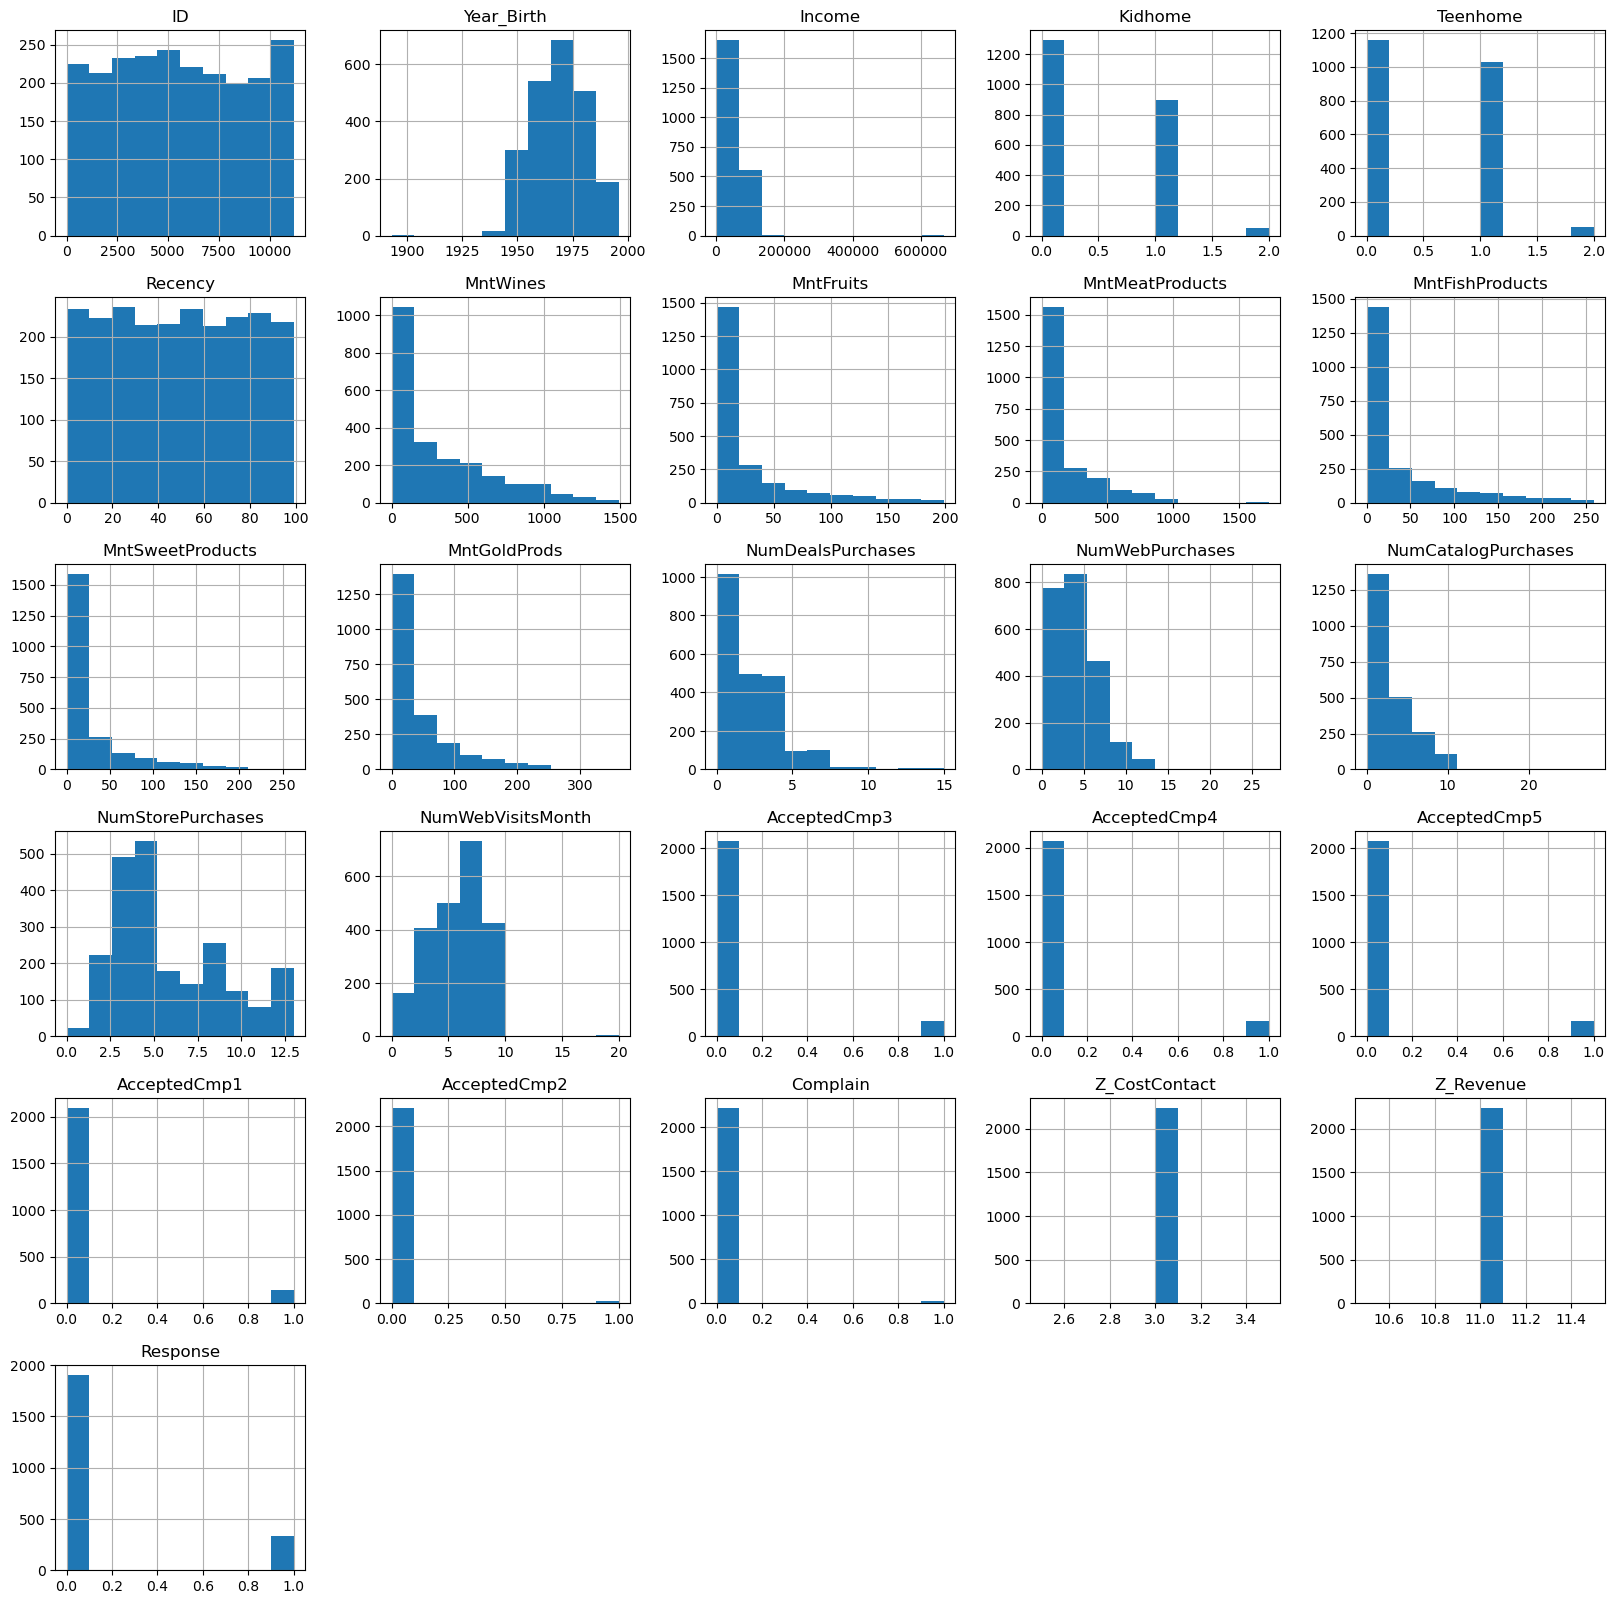

In [7]:
# гистаграммы всех признаков
df.hist(figsize=(20,20))
plt.show()


Топ-10 корреляций с общими тратами:
MntWines               0.891839
MntMeatProducts        0.842965
NumCatalogPurchases    0.778577
Total_Purchases        0.753903
NumStorePurchases      0.674669
Income                 0.667576
MntFishProducts        0.642818
Avg_Check              0.617745
MntFruits              0.614229
MntSweetProducts       0.603016
Name: Total_Spending, dtype: float64


<Figure size 1000x800 with 0 Axes>

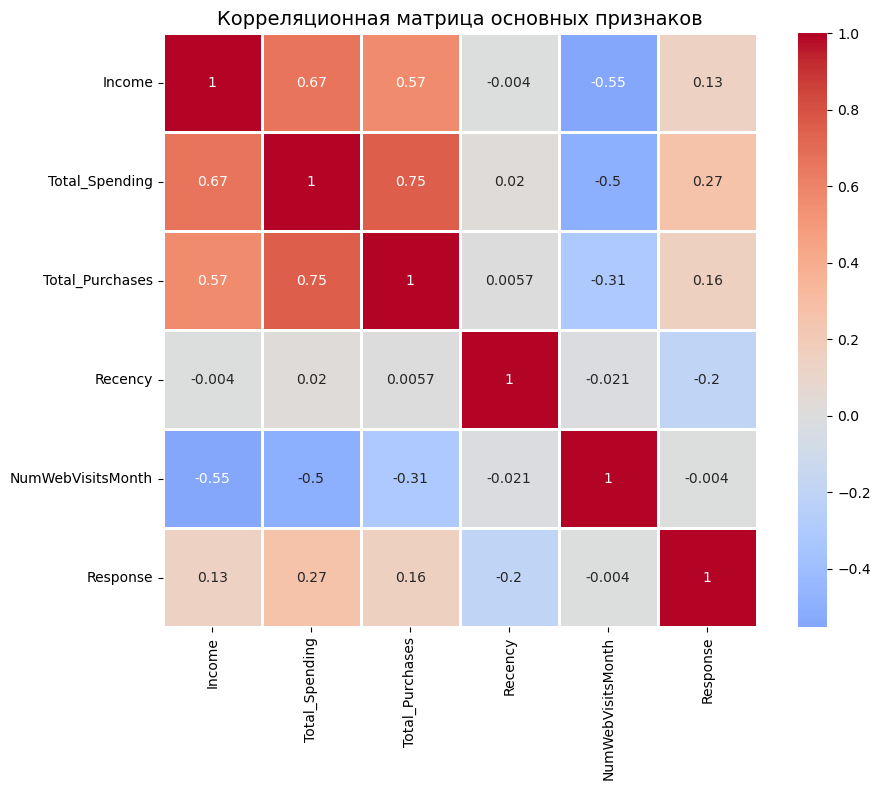

In [23]:
numeric_cols = df_eda.select_dtypes(include=[np.number]).columns
corr_matrix = df_eda[numeric_cols].corr()

# Топ корреляций с Total_Spending
if 'Total_Spending' in corr_matrix.columns:
    top_corr = corr_matrix['Total_Spending'].sort_values(ascending=False)[1:11]
    print("\nТоп-10 корреляций с общими тратами:")
    print(top_corr)

# Тепловая карта (только основные признаки)
main_features = ['Income', 'Total_Spending', 
                 'Total_Purchases', 'Recency', 'NumWebVisitsMonth', 
                  'Response']

plt.figure(figsize=(10, 8))
sns.heatmap(df_eda[main_features].corr(), 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1)
plt.title('Корреляционная матрица основных признаков', fontsize=14)
plt.tight_layout()
plt.show()

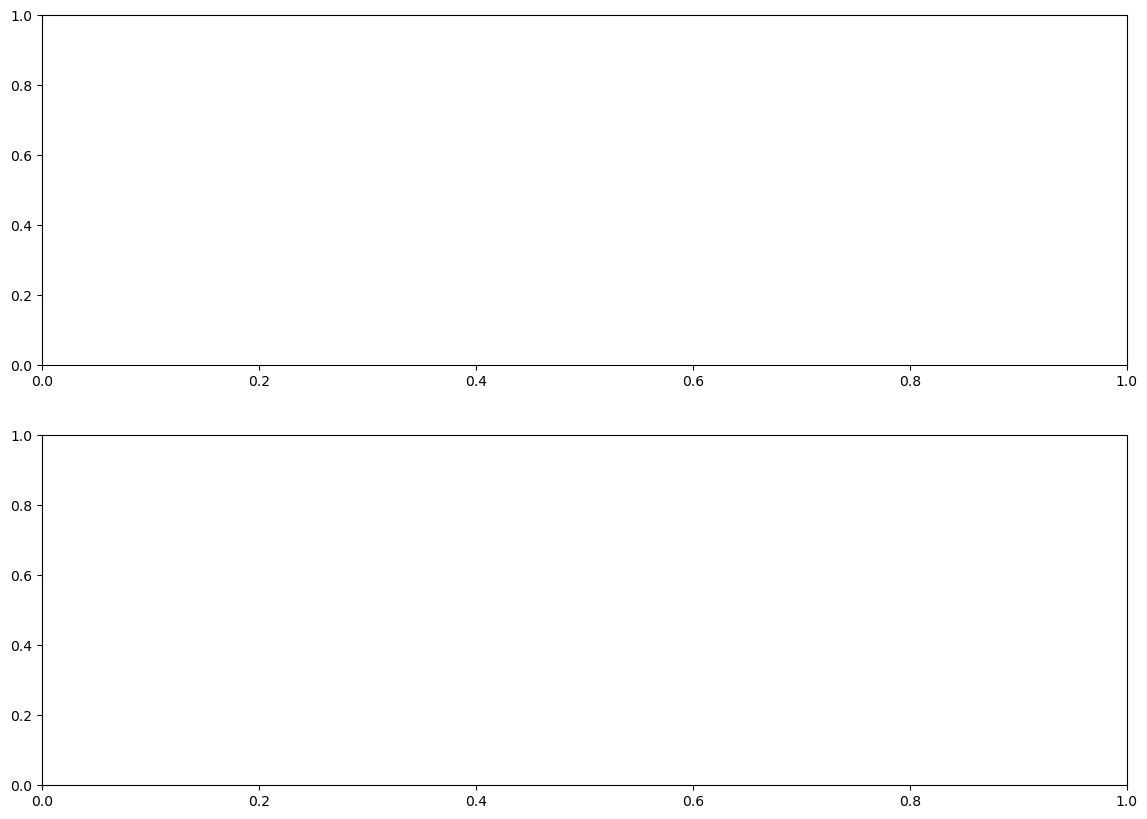

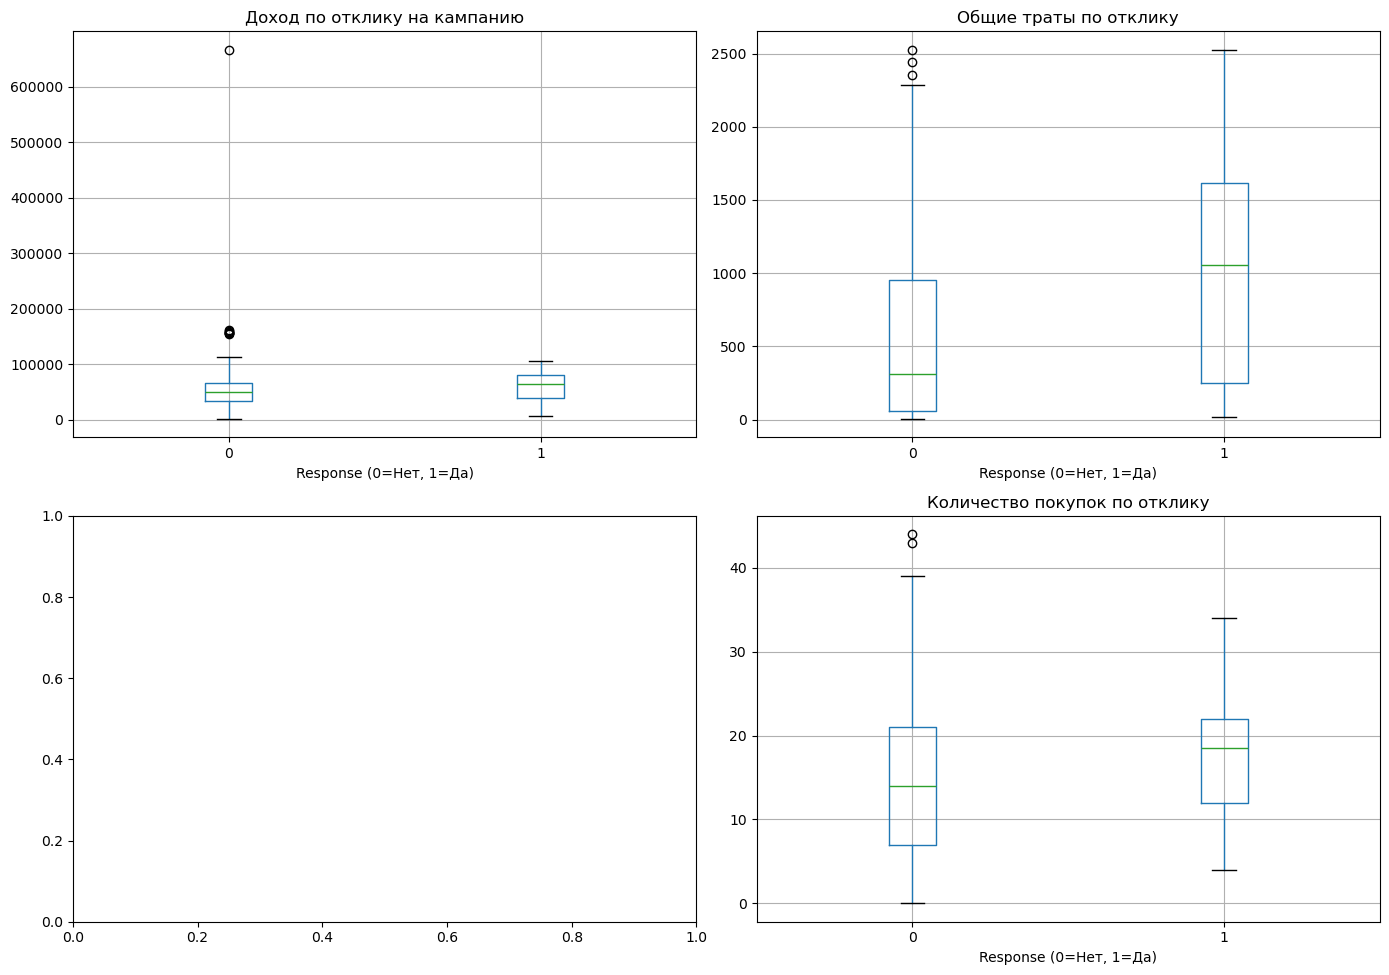


Сравнение Responders vs Non-responders:
                Income  Total_Spending  Total_Purchases
Response                                               
0         50839.132767      538.929171        14.363589
1         60209.675676      987.392216        17.706587


In [30]:
# Сравнение Responders vs Non-responders
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Доход по Response
df_eda.boxplot(column='Income', by='Response', ax=axes[0, 0])
axes[0, 0].set_title('Доход по отклику на кампанию')
axes[0, 0].set_xlabel('Response (0=Нет, 1=Да)')

# Траты по Response
df_eda.boxplot(column='Total_Spending', by='Response', ax=axes[0, 1])
axes[0, 1].set_title('Общие траты по отклику')
axes[0, 1].set_xlabel('Response (0=Нет, 1=Да)')

# Покупки по Response
df_eda.boxplot(column='Total_Purchases', by='Response', ax=axes[1, 1])
axes[1, 1].set_title('Количество покупок по отклику')
axes[1, 1].set_xlabel('Response (0=Нет, 1=Да)')

plt.suptitle('')  # Убираем автоматический заголовок
plt.tight_layout()
plt.show()

# Статистика по группам
print("\nСравнение Responders vs Non-responders:")
response_stats = df_eda.groupby('Response')[['Income', 'Total_Spending', 
                                              'Total_Purchases']].mean()
print(response_stats)

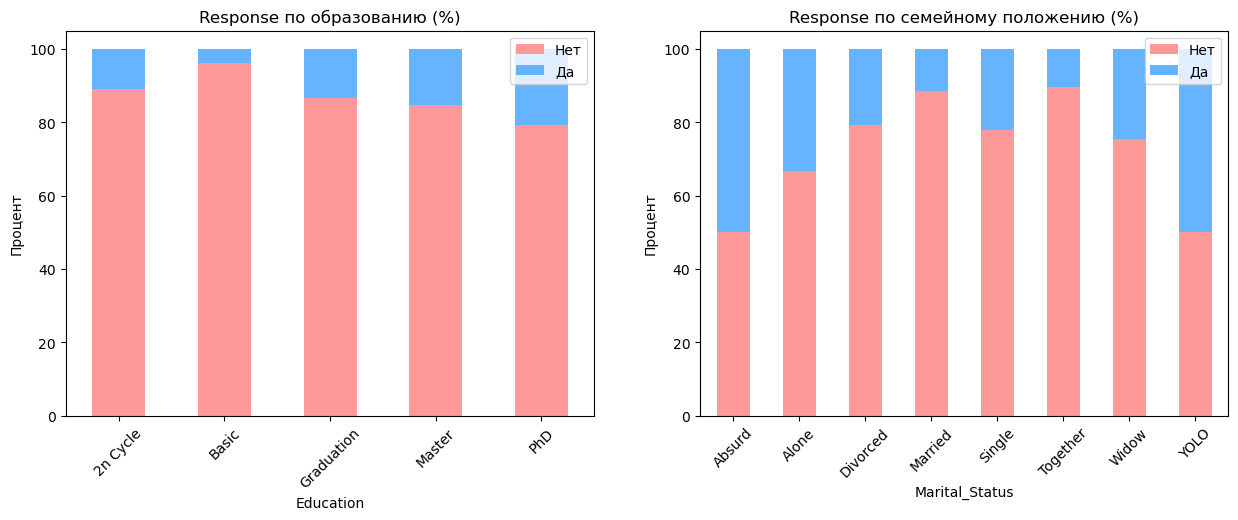

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Response по образованию
edu_response = pd.crosstab(df_eda['Education'], df_eda['Response'], normalize='index') * 100
edu_response.plot(kind='bar', stacked=True, ax=axes[0], color=['#ff9999', '#66b3ff'])
axes[0].set_title('Response по образованию (%)')
axes[0].set_ylabel('Процент')
axes[0].legend(['Нет', 'Да'])
axes[0].tick_params(axis='x', rotation=45)

# Response по семейному положению
marital_response = pd.crosstab(df_eda['Marital_Status'], df_eda['Response'], normalize='index') * 100
marital_response.plot(kind='bar', stacked=True, ax=axes[1], color=['#ff9999', '#66b3ff'])
axes[1].set_title('Response по семейному положению (%)')
axes[1].set_ylabel('Процент')
axes[1].legend(['Нет', 'Да'])
axes[1].tick_params(axis='x', rotation=45)
plt.show()

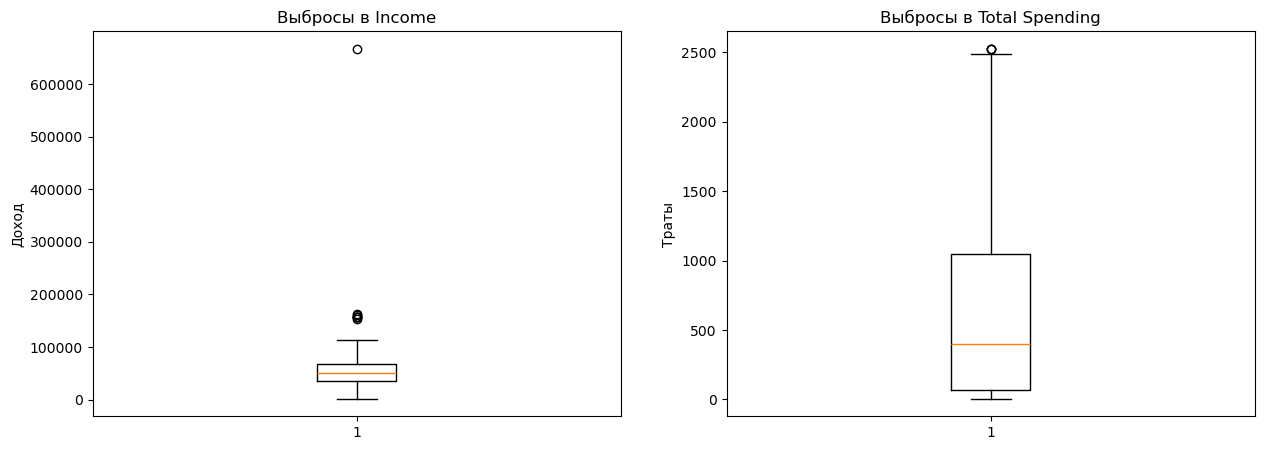


Количество выбросов:
Income: 8 выбросов (0.4%)
Total_Spending: 3 выбросов (0.1%)


In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Boxplot для дохода
axes[0].boxplot(df_eda['Income'].dropna())
axes[0].set_title('Выбросы в Income')
axes[0].set_ylabel('Доход')

# Boxplot для трат
axes[1].boxplot(df_eda['Total_Spending'])
axes[1].set_title('Выбросы в Total Spending')
axes[1].set_ylabel('Траты')
plt.show()

# Количество выбросов по методу IQR
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)

print("\nКоличество выбросов:")
for col in ['Income', 'Total_Spending']:
    if col in df_eda.columns:
        outliers = count_outliers(df_eda[col].dropna())
        print(f"{col}: {outliers} выбросов ({outliers/len(df_eda)*100:.1f}%)")

In [33]:
print(f"""
КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
------------------------
1. Размер датасета: {df_eda.shape[0]} строк, {df_eda.shape[1]} колонок
2. Пропуски:  колонок с пропусками
3. Дубликаты:  полных дубликатов

ДЕМОГРАФИЯ:
- Средний доход: {df_eda['Income'].mean():.0f}
- Самые частые образования: {df_eda['Education'].mode()[0]}

ПОВЕДЕНИЕ:
- Средние траты: {df_eda['Total_Spending'].mean():.0f}
- Среднее количество покупок: {df_eda['Total_Purchases'].mean():.1f}
- Средний отклик на кампании: {df_eda['Response'].mean()*100:.1f}%

ОСНОВНЫЕ ВЫВОДЫ:
1. Клиенты с высоким доходом тратят больше
2. Семьи с детьми имеют другие паттерны покупок
3. Response rate ~{df_eda['Response'].mean()*100:.1f}% - нужно улучшать
""")


КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
------------------------
1. Размер датасета: 2240 строк, 30 колонок
2. Пропуски:  колонок с пропусками
3. Дубликаты:  полных дубликатов

ДЕМОГРАФИЯ:
- Средний доход: 52247
- Самые частые образования: Graduation

ПОВЕДЕНИЕ:
- Средние траты: 606
- Среднее количество покупок: 14.9
- Средний отклик на кампании: 14.9%

ОСНОВНЫЕ ВЫВОДЫ:
1. Клиенты с высоким доходом тратят больше
2. Семьи с детьми имеют другие паттерны покупок
3. Response rate ~14.9% - нужно улучшать

